In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("poster")

%matplotlib inline

In [2]:
colnames = ["chr", "start", "end", "period", "unit"]
df_strs = (
    pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides.bed", sep="\t", header=None, names=colnames)
    .assign(str_id = lambda x: [f"{i}_{j}" for i, j in zip(x["chr"], x["start"])])
)
df_strs

,chr,start,end,period,unit,str_id
0,chr1,14069,14081,4,CCTC,chr1_14069
1,chr1,16619,16631,3,GCT,chr1_16619
2,chr1,22811,22821,5,AGGAA,chr1_22811
3,chr1,26453,26465,2,GT,chr1_26453
4,chr1,28588,28603,1,T,chr1_28588
...,...,...,...,...,...,...
1733641,chrY,57188867,57188878,1,A,chrY_57188867
1733642,chrY,57200837,57200851,1,A,chrY_57200837
1733643,chrY,57200999,57201019,1,A,chrY_57200999
1733644,chrY,57202380,57202403,1,A,chrY_57202380


In [3]:
df_LMO = pd.read_csv("../../data/CRC/variants/CRC0282LMO-0-B_constrain.csv.gz")
df_07_0 = pd.read_csv("../../data/CRC/variants/CRC0282-07-0_constrain.csv.gz")

sample_dict = {
    "df_LMO": df_LMO, 
    "df_07_0": df_07_0, 
}

In [4]:
# sample: (lower, upper)
filter_bounds = {
    "df_LMO": (5.5, 26.5), 
    "df_07_0": (5.5, 26.0),
}

def depth_norm_filter(df, bounds):
    return df.query(f"depth_norm >= {bounds[0]} and depth_norm <= {bounds[1]}").reset_index(drop=True)

In [5]:
df_LMO_filt = depth_norm_filter(df_LMO, filter_bounds["df_LMO"]).dropna().reset_index(drop=True)
df_LMO_filt["copy_number"] = df_LMO_filt["copy_number"].astype(np.int64)
print("LMO:", df_LMO.shape[0], df_LMO_filt.shape[0])

df_07_0_filt = depth_norm_filter(df_07_0, filter_bounds["df_07_0"]).dropna().reset_index(drop=True)
df_07_0_filt["copy_number"] = df_07_0_filt["copy_number"].astype(np.int64)
print("07_0:", df_07_0.shape[0], df_07_0_filt.shape[0])

LMO: 1733646 1620915
07_0: 1733646 1476991


## Simulate WGD event for LMO

In [6]:
def simulate_wgd(genotypes: pd.Series) -> pd.Series:
    wgd = []
    for i in genotypes:
        wgd.append(list(np.repeat(eval(i), 2)))
    return pd.Series(wgd)

In [7]:
wgd = simulate_wgd(df_LMO_filt["genotype"])
df_LMO_filt["genotype_wgd"] = wgd
df_LMO_filt = df_LMO_filt.assign(cn_wgd = lambda x: x["copy_number"] * 2)
df_LMO_filt.head()

,str_id,copy_number,frequencies,genotype,depth,depth_norm,genotype_wgd,cn_wgd
0,chr1_22811,2,{2: 28},"[2, 2]",28,14.0,"[2, 2, 2, 2]",4
1,chr1_26453,2,{6: 44},"[6, 6]",44,22.0,"[6, 6, 6, 6]",4
2,chr1_28588,2,"{10: 1, 15: 10, 16: 4, 17: 1}","[15, 16]",16,8.0,"[15, 15, 16, 16]",4
3,chr1_31555,2,{3: 23},"[3, 3]",23,11.5,"[3, 3, 3, 3]",4
4,chr1_31719,2,"{9: 1, 10: 15, 11: 3, 12: 9, 14: 1}","[10, 12]",29,14.5,"[10, 10, 12, 12]",4


In [8]:
df_comp = (df_LMO_filt
             .merge(df_07_0_filt,
                    left_on=["str_id", "cn_wgd"],
                    right_on=["str_id", "copy_number"],
                    suffixes=("_LMO", "_07_0"),
                    how="inner")
             .drop("genotype_LMO", axis=1)
             .merge(df_strs[["str_id", "period", "unit"]], on="str_id")
             .rename(columns={"cn_wgd": "copy_number_LMO", "genotype_wgd": "genotype_LMO"}))
df_comp = df_comp.assign(genotype_07_0 = lambda x: [eval(i) for i in x["genotype_07_0"]])
print(df_LMO_filt.shape, df_07_0_filt.shape)
print(df_comp.shape)
df_comp.head()

(1620915, 8) (1476991, 6)
(1048272, 14)


,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit
0,chr1_890446,2,"{9: 1, 10: 15, 11: 2, 12: 25}",43,21.5,"[10, 10, 12, 12]",4,4,"{9: 1, 10: 19, 11: 1, 12: 13, 13: 2}","[10, 10, 12, 12]",36,9.00,1,A
1,chr1_894130,2,{7: 36},36,18.0,"[7, 7, 7, 7]",4,4,{7: 35},"[7, 7, 7, 7]",35,8.75,2,TG
2,chr1_894493,2,{2: 39},39,19.5,"[2, 2, 2, 2]",4,4,{2: 23},"[2, 2, 2, 2]",23,5.75,4,GGAG
3,chr1_899024,2,"{14: 4, 15: 14, 16: 1, 18: 1, 20: 3, 21: 18, 2...",42,21.0,"[15, 15, 21, 21]",4,4,"{11: 1, 14: 1, 15: 19, 16: 2, 18: 1, 19: 2, 20...","[15, 15, 19, 21]",38,9.50,1,T
4,chr1_904439,2,{3: 35},35,17.5,"[3, 3, 3, 3]",4,4,{3: 41},"[3, 3, 3, 3]",41,10.25,3,CTC


In [9]:
def find_new_alleles(df, suffixes):
    left, right = suffixes
    match = np.full(df.shape[0], False)
    new_gt_allele = np.full(df.shape[0], False)
    unobserved_gt_allele = np.full(df.shape[0], False)
    for i, j in df.iterrows():
        # print(j[f"genotype{left}"], j[f"genotype{right}"], j[f"genotype{left}"] == j[f"genotype{right}"])
        if j[f"genotype{left}"] == j[f"genotype{right}"]:
            match[i] = True
            continue        
        diff = set(j[f"genotype{left}"]).symmetric_difference(set(j[f"genotype{right}"]))
        # print(i, set(j[f"genotype{left}"]), set(j[f"genotype{right}"]), diff)
        if len(diff) == 0:
            continue
            
        new_gt_allele[i] = True
        left_alleles = eval(j[f"frequencies{left}"]).keys()
        right_alleles = eval(j[f"frequencies{right}"]).keys()
        if len(diff.intersection(left_alleles)) == 0 or len(diff.intersection(right_alleles)) == 0:
            unobserved_gt_allele[i] = True

    return match, new_gt_allele, unobserved_gt_allele

In [10]:
match, new, unobs = find_new_alleles(df_comp, ("_LMO", "_07_0"))
df_comp["match"] = match
df_comp["new_allele"] = new
df_comp["unobserved_allele"] = unobs
print(df_comp.shape)
df_comp.head()

(1048272, 17)


,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
0,chr1_890446,2,"{9: 1, 10: 15, 11: 2, 12: 25}",43,21.5,"[10, 10, 12, 12]",4,4,"{9: 1, 10: 19, 11: 1, 12: 13, 13: 2}","[10, 10, 12, 12]",36,9.00,1,A,True,False,False
1,chr1_894130,2,{7: 36},36,18.0,"[7, 7, 7, 7]",4,4,{7: 35},"[7, 7, 7, 7]",35,8.75,2,TG,True,False,False
2,chr1_894493,2,{2: 39},39,19.5,"[2, 2, 2, 2]",4,4,{2: 23},"[2, 2, 2, 2]",23,5.75,4,GGAG,True,False,False
3,chr1_899024,2,"{14: 4, 15: 14, 16: 1, 18: 1, 20: 3, 21: 18, 2...",42,21.0,"[15, 15, 21, 21]",4,4,"{11: 1, 14: 1, 15: 19, 16: 2, 18: 1, 19: 2, 20...","[15, 15, 19, 21]",38,9.50,1,T,False,True,True
4,chr1_904439,2,{3: 35},35,17.5,"[3, 3, 3, 3]",4,4,{3: 41},"[3, 3, 3, 3]",41,10.25,3,CTC,True,False,False


In [11]:
# df_comp.groupby("period", as_index=False).value_counts(["match", "new_allele", "unobserved_allele"])
df_comp.query("period <= 6").groupby("period", as_index=False).value_counts(["match"], normalize=True)

,period,match,proportion
0,1,True,0.559866
1,1,False,0.440134
2,2,True,0.908499
3,2,False,0.091501
4,3,True,0.987417
5,3,False,0.012583
6,4,True,0.990813
7,4,False,0.009187
8,5,True,0.994578
9,5,False,0.005422


In [12]:
print(df_comp.query("period == 1").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp.query("period == 2").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp.query("period > 2").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))


match  new_allele  unobserved_allele
True   False       False                0.559866
False  True        False                0.301598
       False       False                0.107396
       True        True                 0.031139
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.908499
False  False       False                0.040929
       True        False                0.039529
                   True                 0.011044
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.991357
False  False       False                0.006496
       True        False                0.001757
                   True                 0.000390
Name: proportion, dtype: float64


In [13]:
print(df_comp.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))
print()
print(df_comp.query("period > 2 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10").value_counts(["match", "new_allele", "unobserved_allele"], normalize=True))


match  new_allele  unobserved_allele
True   False       False                0.647383
False  True        False                0.253019
       False       False                0.078189
       True        True                 0.021409
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.971042
False  False       False                0.013951
       True        False                0.012471
                   True                 0.002536
Name: proportion, dtype: float64

match  new_allele  unobserved_allele
True   False       False                0.997167
False  False       False                0.002035
       True        False                0.000756
                   True                 0.000041
Name: proportion, dtype: float64


In [14]:
print(df_comp.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10").shape)
p1 = df_comp.query(
    "period == 1 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)

print(df_comp.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10").shape)
p2 = df_comp.query(
    "period == 2 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)

print(df_comp.query("period > 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10").shape)
p3_6 = df_comp.query(
    "period > 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10"
).value_counts(["match", "new_allele", "unobserved_allele"], normalize=True)


(98044, 17)
(4731, 17)
(71155, 17)


In [15]:
df_plot = pd.concat([
    pd.DataFrame(p1).reset_index().assign(period = "1"), 
    pd.DataFrame(p2).reset_index().assign(period = "2"), 
    pd.DataFrame(p3_6).reset_index().assign(period = "3-6")
])

genotype_match = []
for i, j in df_plot.iterrows():
    if j["match"]:
        genotype_match.append("match")
        continue    
    elif j["unobserved_allele"]:
        genotype_match.append("unobserved_allele")
        continue
    elif j["new_allele"]:
        genotype_match.append("new_allele")
        continue
    genotype_match.append("allele_shift")
genotype_match = pd.Categorical(genotype_match, categories=["match", "allele_shift", "new_allele", "unobserved_allele"], ordered=True)
df_plot["genotype_match"] = genotype_match

df_plot

,match,new_allele,unobserved_allele,proportion,period,genotype_match
0,True,False,False,0.647383,1,match
1,False,True,False,0.253019,1,new_allele
2,False,False,False,0.078189,1,allele_shift
3,False,True,True,0.021409,1,unobserved_allele
0,True,False,False,0.971042,2,match
1,False,False,False,0.013951,2,allele_shift
2,False,True,False,0.012471,2,new_allele
3,False,True,True,0.002536,2,unobserved_allele
0,True,False,False,0.997147,3-6,match
1,False,False,False,0.002066,3-6,allele_shift


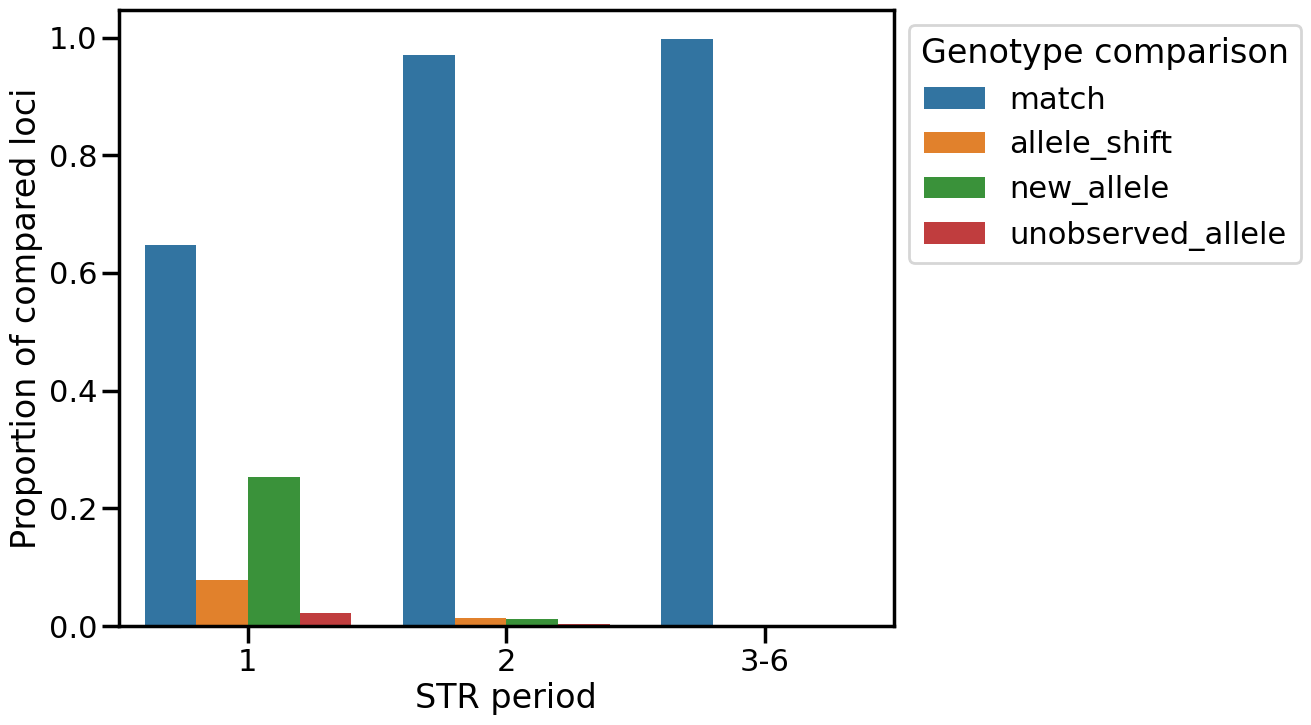

In [16]:
fig = plt.figure(figsize=(10, 8))

ax = sns.barplot(
    data = df_plot,
    x="period",
    y="proportion",
    hue="genotype_match"
)

_ = ax.get_legend().set(
    bbox_to_anchor=(1, 1),
    title="Genotype comparison"
)

_ = ax.set(
    xlabel="STR period",
    ylabel="Proportion of compared loci"
)

In [86]:
df_muts = pd.concat([
    # df_comp.query("period == 1 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10 and not match"),
    # df_comp.query("period == 2 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10 and not match"),
    df_comp.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_07_0 >= 5 and not match"),
]).reset_index(drop=True)

df_muts = df_muts.drop(["copy_number_LMO", "genotype_LMO"], axis=1).merge(
    df_LMO_filt[["str_id", "copy_number", "genotype"]].rename(columns={"copy_number": "copy_number_LMO", "genotype": "genotype_LMO"}),
    on="str_id"
)[['str_id', 'frequencies_LMO', 'depth_LMO', 'depth_norm_LMO', 'copy_number_LMO', 'genotype_LMO',
       'copy_number_07_0', 'frequencies_07_0', 'genotype_07_0', 'depth_07_0',
       'depth_norm_07_0', 'period', 'unit', 'match', 'new_allele',
       'unobserved_allele']]

print(df_comp.query("period > 2 and period <= 6 and depth_norm_LMO >= 5 and depth_norm_07_0 >= 5").shape)
print(df_muts.shape)
print(df_muts.query("unobserved_allele").shape)
df_muts.sample(20, random_state=42)

(432340, 17)
(3755, 16)
(171, 16)


,str_id,frequencies_LMO,depth_LMO,depth_norm_LMO,copy_number_LMO,genotype_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
2148,chr3_196070774,"{10: 1, 11: 16, 13: 3, 14: 6}",26,13.0,2,"[11, 14]",4,"{11: 19, 13: 2, 14: 10}","[11, 11, 11, 14]",31,7.75,3,AAT,False,False,False
1044,chr12_83473271,"{3: 7, 6: 18}",25,12.5,2,"[3, 6]",4,"{3: 8, 6: 18}","[3, 6, 6, 6]",26,6.50,4,AAAT,False,False,False
3321,chr9_6927089,"{9: 1, 10: 13, 13: 11}",25,12.5,2,"[10, 13]",4,"{10: 17, 13: 7}","[10, 10, 10, 13]",24,6.00,4,TCTA,False,False,False
439,chr10_7859260,"{8: 13, 11: 22}",35,17.5,2,"[8, 11]",4,"{8: 3, 11: 19}","[8, 11, 11, 11]",22,5.50,4,AATA,False,False,False
3519,chrX_9434564,"{6: 19, 7: 9}",28,14.0,2,"[6, 7]",4,"{6: 19, 7: 5}","[6, 6, 6, 7]",24,6.00,4,TTTA,False,False,False
1849,chr22_47579068,{7: 18},18,9.0,2,"[7, 7]",4,"{6: 4, 7: 19}","[6, 7, 7, 7]",23,5.75,5,TTGTT,False,True,True
93,chr1_37920674,"{3: 19, 4: 16}",35,17.5,2,"[3, 4]",4,"{3: 12, 4: 21}","[3, 4, 4, 4]",33,8.25,3,AAG,False,False,False
1281,chr17_51022943,"{10: 25, 11: 1}",26,13.0,2,"[10, 10]",4,"{9: 4, 10: 19}","[9, 10, 10, 10]",23,5.75,3,AAT,False,True,True
3581,chrX_45846508,"{8: 17, 9: 2, 10: 11}",30,15.0,2,"[8, 10]",4,"{8: 17, 10: 5}","[8, 8, 8, 10]",22,5.50,4,TTTA,False,False,False
1272,chr17_47509589,"{9: 1, 10: 16, 12: 16, 14: 1, 16: 1}",35,17.5,2,"[10, 12]",4,"{10: 14, 12: 8, 16: 2, 17: 1}","[10, 10, 12, 16]",25,6.25,3,AAT,False,True,False


In [18]:
df_comp.query(
    "period == 1 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10 and not match"
).head(10)

,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
43,chr1_1002415,2,"{12: 1, 13: 9, 14: 12, 15: 17}",39,19.5,"[14, 14, 15, 15]",4,4,"{13: 12, 14: 22, 15: 6, 16: 3}","[13, 14, 14, 15]",43,10.75,1,T,False,True,False
44,chr1_1002640,2,"{9: 1, 10: 3, 11: 36, 12: 4}",44,22.0,"[11, 11, 11, 11]",4,4,"{9: 2, 10: 13, 11: 29, 12: 2}","[10, 11, 11, 11]",46,11.50,1,T,False,True,False
83,chr1_1098076,2,"{10: 1, 11: 6, 12: 33}",40,20.0,"[12, 12, 12, 12]",4,4,"{10: 1, 11: 13, 12: 37}","[11, 12, 12, 12]",51,12.75,1,T,False,True,False
92,chr1_1111365,2,"{12: 1, 13: 2, 14: 26, 15: 12, 16: 3}",44,22.0,"[14, 14, 15, 15]",4,4,"{12: 1, 13: 7, 14: 30, 15: 4}","[13, 14, 14, 14]",42,10.50,1,A,False,True,False
96,chr1_1113913,2,"{11: 2, 12: 27, 13: 21, 14: 1, 15: 1}",52,26.0,"[12, 12, 13, 13]",4,4,"{9: 1, 11: 1, 12: 29, 13: 13, 14: 1}","[12, 12, 12, 13]",45,11.25,1,T,False,False,False
104,chr1_1138569,2,"{13: 3, 14: 30, 15: 4}",37,18.5,"[14, 14, 14, 14]",4,4,"{12: 1, 13: 7, 14: 36, 15: 5}","[13, 14, 14, 14]",49,12.25,1,A,False,True,False
113,chr1_1178561,2,"{11: 1, 12: 10, 13: 20, 14: 12}",43,21.5,"[13, 13, 14, 14]",4,4,"{12: 10, 13: 18, 14: 16, 15: 1}","[12, 13, 13, 14]",45,11.25,1,A,False,True,False
144,chr1_1256888,2,"{11: 2, 12: 21, 13: 16, 14: 1, 15: 1, 16: 1, 1...",43,21.5,"[12, 12, 13, 13]",4,4,"{10: 2, 11: 3, 12: 22, 13: 12, 15: 1, 16: 1}","[11, 12, 12, 13]",41,10.25,1,A,False,True,False
157,chr1_1278491,2,"{14: 1, 15: 1, 16: 8, 17: 30, 18: 6, 19: 1}",47,23.5,"[16, 16, 17, 17]",4,4,"{14: 1, 15: 2, 16: 7, 17: 28, 18: 3}","[16, 17, 17, 17]",41,10.25,1,T,False,False,False
189,chr1_1370553,2,"{14: 13, 15: 28, 16: 5, 18: 1}",47,23.5,"[14, 14, 15, 15]",4,4,"{12: 1, 13: 1, 14: 8, 15: 42, 16: 3}","[14, 15, 15, 15]",55,13.75,1,A,False,False,False


In [51]:
df_comp.query(
    "period >= 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10 and not match and not new_allele"
)

,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
778,chr1_2449499,2,"{7: 14, 9: 17}",31,15.5,"[7, 7, 9, 9]",4,4,"{7: 14, 9: 31}","[7, 9, 9, 9]",45,11.25,4,AACC,False,False,False
1687,chr1_5250903,2,"{10: 1, 11: 8, 12: 12}",21,10.5,"[11, 11, 12, 12]",4,4,"{10: 1, 11: 29, 12: 11}","[11, 11, 11, 12]",41,10.25,2,AC,False,False,False
6019,chr1_11648972,2,"{4: 36, 5: 13}",49,24.5,"[4, 4, 5, 5]",4,4,"{4: 34, 5: 14}","[4, 4, 4, 5]",48,12.00,5,CAGCC,False,False,False
6409,chr1_12159735,2,"{6: 19, 7: 15}",34,17.0,"[6, 6, 7, 7]",4,4,"{6: 26, 7: 15}","[6, 6, 6, 7]",41,10.25,2,TA,False,False,False
6921,chr1_13368089,2,"{4: 37, 5: 15}",52,26.0,"[4, 4, 5, 5]",4,4,"{4: 30, 5: 13}","[4, 4, 4, 5]",43,10.75,4,AAAC,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996658,chr9_130420470,2,"{5: 24, 6: 18}",42,21.0,"[5, 5, 6, 6]",4,4,"{5: 28, 6: 15}","[5, 5, 5, 6]",43,10.75,5,AAAAC,False,False,False
1000318,chr9_137403422,2,"{4: 21, 5: 28}",49,24.5,"[4, 4, 5, 5]",4,4,"{4: 16, 5: 36}","[4, 5, 5, 5]",52,13.00,3,CAG,False,False,False
1007092,chrX_17009160,2,"{2: 19, 3: 26}",45,22.5,"[2, 2, 3, 3]",4,4,"{2: 9, 3: 32}","[2, 3, 3, 3]",41,10.25,4,TTTG,False,False,False
1019573,chrX_52918734,2,"{5: 18, 6: 19}",37,18.5,"[5, 5, 6, 6]",4,4,"{5: 10, 6: 30}","[5, 6, 6, 6]",40,10.00,2,TC,False,False,False


In [48]:
df_comp.query(
    "period >= 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10 and unobserved_allele"
)

,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
23211,chr1_38063862,2,{7: 45},45,22.5,"[7, 7, 7, 7]",4,4,"{6: 14, 7: 30}","[6, 7, 7, 7]",44,11.00,2,GA,False,True,True
69931,chr1_155186468,2,"{12: 1, 13: 38}",39,19.5,"[13, 13, 13, 13]",4,4,"{12: 4, 13: 32, 14: 4}","[13, 13, 13, 14]",40,10.00,2,GT,False,True,True
193812,chr11_35568392,2,"{7: 47, 8: 2}",49,24.5,"[7, 7, 7, 7]",4,4,"{6: 9, 7: 37}","[6, 7, 7, 7]",46,11.50,2,AG,False,True,True
276402,chr12_69405009,2,"{6: 23, 7: 9}",32,16.0,"[6, 6, 7, 7]",4,4,{6: 40},"[6, 6, 6, 6]",40,10.00,2,AG,False,True,True
342195,chr15_82105005,1,{13: 19},19,19.0,"[13, 13]",2,2,"{11: 1, 12: 14, 13: 6}","[12, 13]",21,10.50,3,TAT,False,True,True
387583,chr17_60121169,2,{7: 34},34,17.0,"[7, 7, 7, 7]",4,4,"{6: 9, 7: 43}","[6, 7, 7, 7]",52,13.00,2,AC,False,True,True
396393,chr17_73615773,2,{6: 48},48,24.0,"[6, 6, 6, 6]",4,4,"{5: 12, 6: 30}","[5, 6, 6, 6]",42,10.50,2,AC,False,True,True
398285,chr17_76266414,2,"{6: 1, 7: 40}",41,20.5,"[7, 7, 7, 7]",4,4,"{7: 38, 8: 6}","[7, 7, 7, 8]",44,11.00,2,CA,False,True,True
478990,chr20_367867,2,{7: 27},27,13.5,"[7, 7, 7, 7]",4,4,"{6: 12, 7: 28}","[6, 7, 7, 7]",40,10.00,2,TC,False,True,True
529097,chr3_23946030,2,{8: 39},39,19.5,"[8, 8, 8, 8]",4,4,"{7: 14, 8: 29}","[7, 8, 8, 8]",43,10.75,2,GC,False,True,True


In [24]:
df_comp.query(
    "period >= 2 and period <= 6 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10 and unobserved_allele"
)

,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
23211,chr1_38063862,2,{7: 45},45,22.5,"[7, 7, 7, 7]",4,4,"{6: 14, 7: 30}","[6, 7, 7, 7]",44,11.00,2,GA,False,True,True
69931,chr1_155186468,2,"{12: 1, 13: 38}",39,19.5,"[13, 13, 13, 13]",4,4,"{12: 4, 13: 32, 14: 4}","[13, 13, 13, 14]",40,10.00,2,GT,False,True,True
193812,chr11_35568392,2,"{7: 47, 8: 2}",49,24.5,"[7, 7, 7, 7]",4,4,"{6: 9, 7: 37}","[6, 7, 7, 7]",46,11.50,2,AG,False,True,True
276402,chr12_69405009,2,"{6: 23, 7: 9}",32,16.0,"[6, 6, 7, 7]",4,4,{6: 40},"[6, 6, 6, 6]",40,10.00,2,AG,False,True,True
342195,chr15_82105005,1,{13: 19},19,19.0,"[13, 13]",2,2,"{11: 1, 12: 14, 13: 6}","[12, 13]",21,10.50,3,TAT,False,True,True
387583,chr17_60121169,2,{7: 34},34,17.0,"[7, 7, 7, 7]",4,4,"{6: 9, 7: 43}","[6, 7, 7, 7]",52,13.00,2,AC,False,True,True
396393,chr17_73615773,2,{6: 48},48,24.0,"[6, 6, 6, 6]",4,4,"{5: 12, 6: 30}","[5, 6, 6, 6]",42,10.50,2,AC,False,True,True
398285,chr17_76266414,2,"{6: 1, 7: 40}",41,20.5,"[7, 7, 7, 7]",4,4,"{7: 38, 8: 6}","[7, 7, 7, 8]",44,11.00,2,CA,False,True,True
478990,chr20_367867,2,{7: 27},27,13.5,"[7, 7, 7, 7]",4,4,"{6: 12, 7: 28}","[6, 7, 7, 7]",40,10.00,2,TC,False,True,True
529097,chr3_23946030,2,{8: 39},39,19.5,"[8, 8, 8, 8]",4,4,"{7: 14, 8: 29}","[7, 8, 8, 8]",43,10.75,2,GC,False,True,True


In [76]:
# chr15_55282912
# chr3_19287572 (?)
df_comp.query("str_id == 'chr9_98110848'")

,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
978773,chr9_98110848,2,{10: 31},31,15.5,"[10, 10, 10, 10]",4,4,{10: 33},"[10, 10, 10, 10]",33,8.25,5,AAAAT,True,False,False


In [20]:
df_comp.query(
    "period == 1 and depth_norm_LMO >= 10 and depth_norm_07_0 >= 10 and unobserved_allele"
).head(10)

,str_id,copy_number_LMO,frequencies_LMO,depth_LMO,depth_norm_LMO,genotype_LMO,copy_number_LMO,copy_number_07_0,frequencies_07_0,genotype_07_0,depth_07_0,depth_norm_07_0,period,unit,match,new_allele,unobserved_allele
452,chr1_1816644,2,"{11: 2, 12: 26, 14: 17, 15: 3, 16: 1}",49,24.5,"[12, 12, 14, 14]",4,4,"{10: 1, 11: 1, 12: 23, 13: 9, 14: 5, 16: 1}","[12, 12, 13, 14]",40,10.00,1,T,False,True,True
534,chr1_1896396,2,"{10: 23, 11: 1, 12: 2, 13: 16, 14: 5}",47,23.5,"[10, 10, 13, 13]",4,4,"{9: 12, 10: 7, 11: 1, 12: 1, 13: 26, 14: 1}","[9, 10, 13, 13]",48,12.00,1,T,False,True,True
1320,chr1_4227044,2,"{12: 25, 13: 19}",44,22.0,"[12, 12, 13, 13]",4,4,"{11: 10, 12: 24, 13: 9, 14: 2}","[11, 12, 12, 13]",45,11.25,1,T,False,True,True
1963,chr1_6029281,2,"{14: 1, 15: 11, 17: 4, 18: 4, 19: 5, 20: 3}",28,14.0,"[15, 15, 19, 19]",4,4,"{14: 3, 15: 11, 16: 5, 18: 2, 19: 17, 20: 4}","[15, 16, 19, 19]",42,10.50,1,A,False,True,True
2115,chr1_6292889,2,"{12: 1, 14: 16, 15: 13, 16: 3}",33,16.5,"[14, 14, 15, 15]",4,4,"{13: 8, 14: 14, 15: 20, 16: 2, 18: 1}","[13, 14, 15, 15]",45,11.25,1,T,False,True,True
2159,chr1_6366590,2,"{10: 15, 13: 14, 14: 1, 15: 1}",31,15.5,"[10, 10, 13, 13]",4,4,"{9: 7, 10: 11, 12: 1, 13: 20, 14: 3, 15: 1}","[9, 10, 13, 13]",43,10.75,1,A,False,True,True
2343,chr1_6623505,2,{10: 48},48,24.0,"[10, 10, 10, 10]",4,4,"{8: 1, 9: 9, 10: 40}","[9, 10, 10, 10]",50,12.50,1,A,False,True,True
2387,chr1_6687278,2,"{10: 32, 11: 17}",49,24.5,"[10, 10, 11, 11]",4,4,"{9: 12, 10: 14, 11: 17}","[9, 10, 11, 11]",43,10.75,1,A,False,True,True
3521,chr1_8536104,2,"{10: 12, 14: 3, 15: 12, 17: 2}",29,14.5,"[10, 10, 15, 15]",4,4,"{10: 16, 13: 1, 14: 4, 15: 12, 16: 5, 17: 2}","[10, 10, 15, 16]",40,10.00,1,A,False,True,True
3590,chr1_8627597,2,"{11: 1, 12: 17, 13: 15, 14: 2, 15: 1}",36,18.0,"[12, 12, 13, 13]",4,4,"{10: 10, 11: 1, 12: 23, 13: 17, 14: 2, 15: 1}","[10, 12, 12, 13]",54,13.50,1,A,False,True,True
